# SYBILCAST Crime Prediction

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in data from S3

In [2]:
# Read in data from S3 
url ="https://crime-bucket.s3.amazonaws.com/df_final.csv_part-00000-tid-4707133912382694247-c7f8a1f6-f632-416d-bd19-0c2a3ebeba4d-27-1-c000.csv"
df = pd.read_csv(url)
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,DATE,MONTH,SEASON,day_night
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0913 1814 2000,48,M,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AA,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,02/20/2010,2,winter,day
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,09/12/2010,9,fall,night
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,0344,0,M,H,103.0,ALLEY,NaN,NaN,IC,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,08/09/2010,8,summer,day
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,1100 0400 1402,47,F,W,101.0,STREET,102.0,HAND GUN,IC,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,01/05/2010,1,winter,night
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",0400,47,F,H,103.0,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,01/02/2010,1,winter,night


# Data Pre-processing

Include the following features for the ML model:
- Area Name (Newton, Hollywood, Central, Southwest, Rampart, Olympic, Northeast, 77th Street, Hollenbeck, Harbor, Pacific, Southeast, Wilshire, West LA, Van Nuys, West Valley, N Hollywood, Mission, Topanga, Devonshire, Foothill)
- Victim's Age
- Victim's Sex
- Victim's Descent
- Premise Description (type of location where the crime occured)
- Latitude (the latitude where the crime occured)
- Longitude (the longitude where the crime occured)
- Season (the season during which the crime occured
- Day or Night (whether the crime occuring during the day or during the night)

In [3]:
# Include only relevant columns
cols = ['Crm Cd','Crm Cd Desc','AREA NAME', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Desc', 'LAT', 'LON', 'SEASON', 'day_night']
df_filtered = df[cols]
df_filtered

,Crm Cd,Crm Cd Desc,AREA NAME,Vict Age,Vict Sex,Vict Descent,Premis Desc,LAT,LON,SEASON,day_night
0,900,VIOLATION OF COURT ORDER,Newton,48,M,H,SINGLE FAMILY DWELLING,33.9825,-118.2695,winter,day
1,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",Pacific,0,M,W,STREET,33.9599,-118.3962,fall,night
2,946,OTHER MISCELLANEOUS CRIME,Newton,0,M,H,ALLEY,34.0224,-118.2524,summer,day
3,900,VIOLATION OF COURT ORDER,Hollywood,47,F,W,STREET,34.1016,-118.3295,winter,night
4,122,"RAPE, ATTEMPTED",Central,47,F,H,ALLEY,34.0387,-118.2488,winter,night
...,...,...,...,...,...,...,...,...,...,...,...
2111855,648,ARSON,Hollywood,0,X,X,SEX ORIENTED/BOOK STORE/STRIP CLUB/GENTLEMAN'S...,34.0962,-118.3490,spring,night
2111856,331,THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER),Wilshire,40,M,W,STREET,34.0871,-118.3732,summer,day
2111857,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,Olympic,46,F,B,SIDEWALK,34.0637,-118.2870,winter,night
2111858,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),Devonshire,0,NaN,NaN,STREET,34.2266,-118.5085,fall,day


#### Find mean age for ages non-zero, non-negative, and not 114 or 118

In [4]:
# Find mean age for ages non-zero, non-negative, and not 114 or 118
over_zero = df.loc[df['Vict Age']>0]
over_zero.head()
over_under = over_zero['Vict Age'].loc[over_zero['Vict Age'] < 114].values
mean_age = round(over_under.mean())
print(f'Mean Age : {mean_age}')

Mean Age : 39.0


### Drop crime codes with crime counts under 10,000

In [5]:
# Group DataFrame by Crime Code, count the number of rows, only show first column
code_count = df_filtered.groupby('Crm Cd').count()['AREA NAME']

# Find the indices of the crime codes with counts above 10,000
code_index = code_count.loc[code_count.values>=10000].index

# Create newDf with the rows of only crime codes with counts above 10,000
newDf = df_filtered[df_filtered['Crm Cd'].isin(code_index)]
newDf

,Crm Cd,Crm Cd Desc,AREA NAME,Vict Age,Vict Sex,Vict Descent,Premis Desc,LAT,LON,SEASON,day_night
0,900,VIOLATION OF COURT ORDER,Newton,48,M,H,SINGLE FAMILY DWELLING,33.9825,-118.2695,winter,day
1,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",Pacific,0,M,W,STREET,33.9599,-118.3962,fall,night
2,946,OTHER MISCELLANEOUS CRIME,Newton,0,M,H,ALLEY,34.0224,-118.2524,summer,day
3,900,VIOLATION OF COURT ORDER,Hollywood,47,F,W,STREET,34.1016,-118.3295,winter,night
5,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),Central,23,M,B,DEPARTMENT STORE,34.0480,-118.2577,winter,day
...,...,...,...,...,...,...,...,...,...,...,...
2111853,210,ROBBERY,Van Nuys,30,F,W,STREET,34.2085,-118.4553,winter,night
2111856,331,THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER),Wilshire,40,M,W,STREET,34.0871,-118.3732,summer,day
2111857,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,Olympic,46,F,B,SIDEWALK,34.0637,-118.2870,winter,night
2111858,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),Devonshire,0,NaN,NaN,STREET,34.2266,-118.5085,fall,day


### Drop all rows where victim age is negative, 114, or 118

In [6]:
ageDf = newDf.loc[newDf['Vict Age']>=0]
ageDf = ageDf.loc[ageDf['Vict Age']<114]
ageDf.head()

,Crm Cd,Crm Cd Desc,AREA NAME,Vict Age,Vict Sex,Vict Descent,Premis Desc,LAT,LON,SEASON,day_night
0,900,VIOLATION OF COURT ORDER,Newton,48,M,H,SINGLE FAMILY DWELLING,33.9825,-118.2695,winter,day
1,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",Pacific,0,M,W,STREET,33.9599,-118.3962,fall,night
2,946,OTHER MISCELLANEOUS CRIME,Newton,0,M,H,ALLEY,34.0224,-118.2524,summer,day
3,900,VIOLATION OF COURT ORDER,Hollywood,47,F,W,STREET,34.1016,-118.3295,winter,night
5,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),Central,23,M,B,DEPARTMENT STORE,34.0480,-118.2577,winter,day


### Replace NaN Values for Victim Sex

In [7]:
# USE X (undefined sex) FOR ALL BUT M AND F
ageDf['Vict Sex'].fillna('X',inplace=True)

# Change '-', 'H', and 'N' for victim's sex to X for unknown
ageDf = ageDf.replace({'Vict Sex':{'-':'X'}})
ageDf = ageDf.replace({'Vict Sex':{'H':'X'}})
ageDf = ageDf.replace({'Vict Sex':{'N':'X'}})
ageDf['Vict Sex'].unique()

array(['M', 'F', 'X'], dtype=object)

### Filter out rows where age is 0 and sex is F or M (to account for victimless crimes)

In [8]:
# Find rows where age is 0 and sex is F or M
age_gender = ageDf.copy()
genders = ['N', 'X', 'H']
genders2 = ['F','M']
test_df = age_gender.loc[(age_gender['Vict Age']==0)& age_gender['Vict Sex'].isin(genders2)]
test_df

,Crm Cd,Crm Cd Desc,AREA NAME,Vict Age,Vict Sex,Vict Descent,Premis Desc,LAT,LON,SEASON,day_night
1,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",Pacific,0,M,W,STREET,33.9599,-118.3962,fall,night
2,946,OTHER MISCELLANEOUS CRIME,Newton,0,M,H,ALLEY,34.0224,-118.2524,summer,day
37,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",Central,0,M,H,SIDEWALK,34.0389,-118.2643,winter,day
46,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",Central,0,M,O,STREET,34.0439,-118.2514,winter,night
51,946,OTHER MISCELLANEOUS CRIME,Central,0,M,W,STREET,34.0445,-118.2523,winter,night
...,...,...,...,...,...,...,...,...,...,...,...
2111691,440,THEFT PLAIN - PETTY ($950 & UNDER),West Valley,0,M,W,OTHER BUSINESS,34.2084,-118.5382,summer,night
2111751,440,THEFT PLAIN - PETTY ($950 & UNDER),Mission,0,M,O,HOSPITAL,34.2790,-118.4589,spring,day
2111768,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),N Hollywood,0,M,O,MINI-MART,34.2067,-118.3878,spring,day
2111817,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",Foothill,0,M,O,OTHER STORE,34.2529,-118.2955,fall,day


In [9]:
# Exclude the rows where age is 0 and sex is either Male or Female
merged = pd.concat([ageDf,test_df]).drop_duplicates(keep=False)
merged

,Crm Cd,Crm Cd Desc,AREA NAME,Vict Age,Vict Sex,Vict Descent,Premis Desc,LAT,LON,SEASON,day_night
0,900,VIOLATION OF COURT ORDER,Newton,48,M,H,SINGLE FAMILY DWELLING,33.9825,-118.2695,winter,day
3,900,VIOLATION OF COURT ORDER,Hollywood,47,F,W,STREET,34.1016,-118.3295,winter,night
6,330,BURGLARY FROM VEHICLE,Central,46,M,H,STREET,34.0389,-118.2643,winter,night
7,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Central,51,M,B,OTHER PREMISE,34.0435,-118.2427,winter,night
8,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Central,30,M,H,PARKING LOT,34.0450,-118.2640,winter,night
...,...,...,...,...,...,...,...,...,...,...,...
2111853,210,ROBBERY,Van Nuys,30,F,W,STREET,34.2085,-118.4553,winter,night
2111856,331,THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER),Wilshire,40,M,W,STREET,34.0871,-118.3732,summer,day
2111857,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,Olympic,46,F,B,SIDEWALK,34.0637,-118.2870,winter,night
2111858,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),Devonshire,0,X,NaN,STREET,34.2266,-118.5085,fall,day


### Replace remaining 0 ages with the mean age

In [0]:
final_df = merged.replace({'Vict Age':{0:int(mean_age)}})

### Replace NaN values for Victim Descent and Premise Description

In [0]:
# USE 'X' (unknown) for NaN victim's descent
final_df['Vict Descent'].fillna('X',inplace=True)

# Change '-' for victim's descent to X for unknown
final_df = final_df.replace({'Vict Descent':{'-':'X'}})

# Change NaN Premise Description's to be "Unknown"
final_df['Premis Desc'].fillna('Unknown',inplace=True)

In [12]:
data = final_df.copy()
data.head()

,Crm Cd,Crm Cd Desc,AREA NAME,Vict Age,Vict Sex,Vict Descent,Premis Desc,LAT,LON,SEASON,day_night
0,900,VIOLATION OF COURT ORDER,Newton,48,M,H,SINGLE FAMILY DWELLING,33.9825,-118.2695,winter,day
3,900,VIOLATION OF COURT ORDER,Hollywood,47,F,W,STREET,34.1016,-118.3295,winter,night
6,330,BURGLARY FROM VEHICLE,Central,46,M,H,STREET,34.0389,-118.2643,winter,night
7,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Central,51,M,B,OTHER PREMISE,34.0435,-118.2427,winter,night
8,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Central,30,M,H,PARKING LOT,34.0450,-118.2640,winter,night


### Change the Latitude and Longitude
#### New Latitude is Lat^2
#### New Longitude is Lon^2
#### New Column (Z) is Lat*Lon

In [13]:
data['NEWlat']= data['LAT']**2
data['NEWlon']= data['LON']**2
data['NEW_Z']= data['LAT']*data['LON']

# Change the column names, drop the old LAT and LON columns
data = data[['Crm Cd', 'Crm Cd Desc', 'AREA NAME', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Desc', 'SEASON', 'day_night',
       'NEWlat', 'NEWlon', 'NEW_Z']]
data.head()

,Crm Cd,Crm Cd Desc,AREA NAME,Vict Age,Vict Sex,Vict Descent,Premis Desc,SEASON,day_night,NEWlat,NEWlon,NEW_Z
0,900,VIOLATION OF COURT ORDER,Newton,48,M,H,SINGLE FAMILY DWELLING,winter,day,1154.810306,13987.674630,-4019.093284
3,900,VIOLATION OF COURT ORDER,Hollywood,47,F,W,STREET,winter,night,1162.919123,14001.870570,-4035.225277
6,330,BURGLARY FROM VEHICLE,Central,46,M,H,STREET,winter,night,1158.646713,13986.444654,-4025.586681
7,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Central,51,M,B,OTHER PREMISE,winter,night,1158.959892,13981.336103,-4025.395357
8,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",Central,30,M,H,PARKING LOT,winter,night,1159.062025,13986.373696,-4026.297880


In [14]:
# Show a list of the unique crime descriptions
data['Crm Cd Desc'].unique()

array(['VIOLATION OF COURT ORDER', 'BURGLARY FROM VEHICLE',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'BATTERY - SIMPLE ASSAULT', 'ROBBERY',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'INTIMATE PARTNER - AGGRAVATED ASSAULT',
       'INTIMATE PARTNER - SIMPLE ASSAULT',
       'THEFT PLAIN - PETTY ($950 & UNDER)', 'OTHER MISCELLANEOUS CRIME',
       'CRIMINAL THREATS - NO WEAPON DISPLAYED', 'ATTEMPTED ROBBERY',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'BURGLARY',
       'RAPE, FORCIBLE', 'BRANDISH WEAPON',
       'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
       'VEHICLE - STOLEN', 'THEFT, PERSON', 'TRESPASSING',
       'BATTERY WITH SEXUAL CONTACT', 'DOCUMENT FORGERY / STOLEN FELONY',
       'VIOLATION OF RESTRAINING ORDER',
       'SHOPLIFTING - PETTY THEFT ($950 & UNDER)', 'THEFT OF IDENTITY',
       'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
      

## Group similar crimes:
### Theft, Assault/Battery, Vehicle-Related, Sexual-Related Crimes, Burglary, Robbery, Threats/Disturbances, Violation of Order 

In [16]:
# Count the top words in all Crime Code Descriptions
df = data.copy()
crime_codes = df['Crm Cd Desc'].unique()
import re 
counts = {}
theft_codes = []
for crime in crime_codes:
    for word in crime.split():
        res = re.findall(r'\w+', word)
        if len(res)==1:
            if res[0] in counts:
                counts[res[0]] += 1
            else:
                counts[res[0]] = 1
        if len(res)==2:
            if res[0] in counts:
                counts[res[0]] += 1
            else:
                counts[res[0]] = 1
            if res[1] in counts:
                counts[res[1]] += 1
            else:
                counts[res[1]] = 1
count_df = pd.DataFrame(counts.items())
count_df=count_df.rename(columns={0:'Word',1:'Count'})
top_crime_words = count_df.sort_values('Count',ascending=False)
top_crime_words

,Word,Count
12,THEFT,7
7,ASSAULT,5
14,950,4
6,VEHICLE,4
30,UNDER,4
...,...,...
36,NO,1
37,DISPLAYED,1
39,MISDEAMEANOR,1
40,399,1


### VEHICLE RELATED CRIMES
- Group any crimes that contain 'vehicle' or 'driving'
- Crm Cd = 5000
- Crm Cd Desc = 'VEHICLE-RELATED'

In [0]:
# Find the vehicle-related crime words in the DataFrame of the top crime words
CAR_crimeCount = top_crime_words.loc[(top_crime_words['Word']=='vehicle'.upper()) |
                                    (top_crime_words['Word']=='driving'.upper())]

# Make a list of the vehicle-related crime words
car_words = CAR_crimeCount['Word'].values

# Make a list of the full crime description for vehicle-related crimes
car_crime_names = [crime for crime in crime_codes for word in car_words if crime.find(word) != -1]

# Get the crime codes for each vehicle-related crime
car_codes = []
for name in car_crime_names:
    code = df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values[0]
    car_codes.append(code)

# Replace the crime code description with 'VEHICLE-RELATED' and the code with 5000
for name in car_crime_names:
    df['Crm Cd Desc'].replace({name:'VEHICLE-RELATED'},inplace=True)
for code in car_codes:
    df['Crm Cd'].replace({code:5000},inplace=True)

### SEXUAL RELATED CRIMES
- Group any crimes that contain 'sex', 'rape', 'intimate', 'pimping', 'indecent', or sexual
- Crm Cd = 4000
- Crm Cd Desc = 'SEXUAL-RELATED'

In [0]:
# Need to put this cell before Assault/Battery Crime cell so ASSULT-INTIMATE PARTNER is under SEXUAL-RELATED instead of ASSAULT/BATTERY

# Find the count of sexual-related crime words in the dataset
SEX_crimeCount = top_crime_words.loc[(top_crime_words['Word']=='sex'.upper()) |
                                     (top_crime_words['Word']=='rape'.upper()) |
                                     (top_crime_words['Word']=='intimate'.upper()) |
                                     (top_crime_words['Word']=='pimping'.upper()) |
                                     (top_crime_words['Word']=='indecent'.upper()) |
                                     (top_crime_words['Word']=='sexual'.upper())]

# Make a list of the sexual-related crime words
sex_words = SEX_crimeCount['Word'].values

# Make a list of the full crime description for sexual-related crimes
sex_crime_names = [crime for crime in crime_codes for word in sex_words if crime.find(word) != -1]

# Get the crime codes for each sexual-related crime
sex_codes = []
for name in sex_crime_names:
    code = df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values[0]
    sex_codes.append(code)
    
# Replace the crime code description with 'SEXUAL-RELATED' and the code with 4000
for name in sex_crime_names:
    df['Crm Cd Desc'].replace({name:'SEXUAL-RELATED'},inplace=True)
for code in sex_codes:
    df['Crm Cd'].replace({code:4000},inplace=True)

### THEFT/STEALING CRIMES
- Group any crimes that contain 'theft', 'shoplifing', 'stealing', or 'pickpocket'
- Crm Cd = 1000
- Crm Cd Desc = 'THEFT'

In [0]:
# # Find the count of theft-related crime words in the dataset
THEFT_crimeCount = top_crime_words.loc[(top_crime_words['Word']=='theft'.upper()) |
                    (top_crime_words['Word']=='shoplifting'.upper()) |
                    (top_crime_words['Word']=='stealing'.upper()) |
                    (top_crime_words['Word']=='pickpocket'.upper()) ]

# Make a list of the theft-related crime words
theft_words = THEFT_crimeCount['Word'].values

# Make a list of the full crime description for theft crimes
theft_crime_names = [crime for crime in crime_codes for word in theft_words if crime.find(word) != -1]

#REMOVE THEFT OF IDENTITY
theft_crime_names.remove('THEFT OF IDENTITY')

# Get the crime codes for each theft crime
theft_codes = []
for name in theft_crime_names:
    if (len(df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values))>0:
        code = df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values[0]
        theft_codes.append(code)

# Replace the crime code description with 'THEFT' and the code with 1000
for name in theft_crime_names:
    df['Crm Cd Desc'].replace({name:'THEFT'},inplace=True)
for code in theft_codes:
    df['Crm Cd'].replace({code:1000},inplace=True)

### ASSAULT/BATTERY CRIMES
- Group any crimes that contain 'assault' or 'battery'
- Crm Cd = 2000
- Crm Cd Desc = 'ASSAULT/BATTERY'

In [0]:
# Find the count of assault and battery crime words in dataset
ASSAULT_crimeCount = top_crime_words.loc[(top_crime_words['Word']=='assault'.upper())|
                                         (top_crime_words['Word']=='battery'.upper())]

# Make a list of the assault/battery crime words
assault_words = ASSAULT_crimeCount['Word'].values

# Make a list of the full crime description for assault/battery crimes
assault_crime_names = [crime for crime in crime_codes for word in assault_words if crime.find(word) != -1]

# Get the crime codes for each assault/battery crime
assault_codes = []
for name in assault_crime_names:
    if (len(df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values))>0:
        code = df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values[0]
        assault_codes.append(code)

# Replace the crime code description with 'ASSAULT' and the code with 2000
for name in assault_crime_names:
    df['Crm Cd Desc'].replace({name:'ASSAULT/BATTERY'},inplace=True)
for code in assault_codes:
    df['Crm Cd'].replace({code:2000},inplace=True)

### BURGLARY  CRIMES
- Group any crimes that are 'burglary' or 'burglary, attempted'
- Crm Cd = 3000
- Crm Cd Desc = 'BURGLARY'

In [0]:
# Find the count of burglary crime words in the dataset
BURG_crimeCount = top_crime_words.loc[(top_crime_words['Word']=='burglary'.upper())]

# Make a list of the burglary crime words
burg_words = BURG_crimeCount['Word'].values

# Make a list of the full crime description for burglary crimes
burg_crime_names = [crime for crime in crime_codes for word in burg_words if crime.find(word) != -1]

# Get the crime codes for each burglary crime
burg_codes = []
for name in burg_crime_names:
    if (len(df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values))>0:
        code = df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values[0]
        burg_codes.append(code)

# Replace the crime code description with 'BURGLARY' and the code with 3000
for name in burg_crime_names:
    df['Crm Cd Desc'].replace({name:'BURGLARY'},inplace=True)
for code in burg_codes:
    df['Crm Cd'].replace({code:3000},inplace=True)

### ROBBERY CRIMES
- Group any crimes that are 'robbery' or 'attemped robbery'
- Crm Cd = 6000
- Crm Cd Desc = 'ROBBERY'

In [0]:
# Find the count of robbery crime words in the dataset
ROB_crimeCount = top_crime_words.loc[(top_crime_words['Word']=='ROBBERY'.upper())]

# Make a list of the robbery crime words
rob_words = ROB_crimeCount['Word'].values

# Make a list of the full crime description for robbery crimes
rob_crime_names = [crime for crime in crime_codes for word in rob_words if crime.find(word) != -1]

# Get the crime codes for each robbery crime
rob_codes = []
for name in rob_crime_names:
    if (len(df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values))>0:
        code = df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values[0]
        rob_codes.append(code)

# Replace the crime code description with 'ROBBERY' and the code with 6000
for name in rob_crime_names:
    df['Crm Cd Desc'].replace({name:'ROBBERY'},inplace=True)
for code in rob_codes:
    df['Crm Cd'].replace({code:6000},inplace=True)

### VANDALISM CRIMES
- Group any crimes that are 'vandalism'
- Crm Cd = 7000
- Crm Cd Desc = 'VANDALISM'

In [0]:
# Find the count of vandalism-related crime words in the dataset
VAND_crimeCount = top_crime_words.loc[(top_crime_words['Word']=='VANDALISM'.upper())]

# Make a list of the vandalism crime words
vand_words = VAND_crimeCount['Word'].values

# Make a list of the full crime description for vandalism crimes
vand_crime_names = [crime for crime in crime_codes for word in vand_words if crime.find(word) != -1]

# Get the crime codes for each vandalism crime
vand_codes = []
for name in vand_crime_names:
    if (len(df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values))>0:
        code = df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values[0]
        vand_codes.append(code)

# Replace the crime code description with 'VANDALISM' and the code with 7000
for name in vand_crime_names:
    df['Crm Cd Desc'].replace({name:'VANDALISM'},inplace=True)
for code in vand_codes:
    df['Crm Cd'].replace({code:7000},inplace=True)

### THREAT/DISTURBANCE CRIMES
- Group any crimes that are 'CRIMINAL THREATS - NO WEAPON DISPLAYED', 'BRANDISH WEAPON', 'LETTERS, LEWD - TELEPHONE CALLS, LEWD'
- Crm Cd Desc = 'THREATS/DISTURBANCES'

In [0]:
# Replace the crime code descriptions with "THREATS/DISTURBANCES"
df['Crm Cd Desc'].replace({'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD':'THREATS/DISTURBANCES'}, inplace=True)
df['Crm Cd Desc'].replace({'CRIMINAL THREATS - NO WEAPON DISPLAYED':'THREATS/DISTURBANCES'}, inplace=True)
df['Crm Cd Desc'].replace({'BRANDISH WEAPON':'THREATS/DISTURBANCES'}, inplace=True)

### VIOLATION OF ORDER CRIMES
- Group any crimes that are 'VIOLATION OF COURT ORDER' or 'VIOLATION OF RESTRAINING ORDER'
- Crm Cd = 8000
- Crm Cd Desc = 'VIOLATION OF ORDER'

In [0]:
# Find the count of violation of order crime words in the dataset
VIOL_crimeCount = top_crime_words.loc[(top_crime_words['Word']=='VIOLATION'.upper())]

# Make a list of the violation of order crime words
viol_words = VIOL_crimeCount['Word'].values

# Make a list of the full crime description for violation of order crimes
viol_crime_names = [crime for crime in crime_codes for word in viol_words if crime.find(word) != -1]

# Get the crime codes for each violation of order crime
viol_codes = []
for name in viol_crime_names:
    if (len(df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values))>0:
        code = df.loc[df['Crm Cd Desc']==name]['Crm Cd'].values[0]
        viol_codes.append(code)

# Replace the crime code description with 'VIOLATION OF ORDER' and the code with 8000
for name in viol_crime_names:
    df['Crm Cd Desc'].replace({name:'VIOLATION OF ORDER'},inplace=True)
for code in viol_codes:
    df['Crm Cd'].replace({code:8000},inplace=True)

In [26]:
# Display the new unique crime codes
df['Crm Cd Desc'].unique()

array(['VIOLATION OF ORDER', 'VEHICLE-RELATED', 'ASSAULT/BATTERY',
       'THEFT', 'ROBBERY', 'VANDALISM', 'SEXUAL-RELATED',
       'OTHER MISCELLANEOUS CRIME', 'THREATS/DISTURBANCES', 'BURGLARY',
       'TRESPASSING', 'DOCUMENT FORGERY / STOLEN FELONY',
       'THEFT OF IDENTITY', 'BIKE - STOLEN'], dtype=object)

In [ ]:
# Save the dataframe to a CSV to load into AWS (https://crime-bucket.s3.amazonaws.com/FINAL_DF.csv)
df.to_csv('Data/FINAL_DF.csv')

# PREDICTING CRIME CODE DESCRIPTION

In [0]:
# PREDICTING CRIME CODE DESCRIPTION

# New columns with new Lat/Lon/Z
cols_CrmCdDesc = ['Crm Cd Desc','AREA NAME', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Desc', 'SEASON', 'day_night','NEWlat','NEWlon','NEW_Z']

# Create a DataFrame with only the relevant columns
data_desc = df[cols_CrmCdDesc]

# Create X (features) and y (crime code description)
X_desc = data_desc.drop('Crm Cd Desc',axis=1)
y_desc = data_desc['Crm Cd Desc'].values.reshape(-1,1)

# Dummy Encode the X values
X_encoded_desc = pd.get_dummies(X_desc,columns=['AREA NAME','Vict Sex','Vict Descent','Premis Desc','SEASON','day_night'])

In [0]:
# Train Test Split the model
from sklearn.model_selection import train_test_split
X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(
    X_encoded_desc, y_desc, random_state=122, stratify=y_desc)

In [0]:
# Scale the X values
from sklearn.preprocessing import StandardScaler
X_scaler_desc = StandardScaler().fit(X_train_desc)

X_train_scaled_desc = X_scaler_desc.transform(X_train_desc)
X_test_scaled_desc = X_scaler_desc.transform(X_test_desc)

In [0]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

# Create the SDGClassifier model with loss='log' for logistic regression
model = linear_model.SGDClassifier(loss='log',max_iter=500,verbose=2)

In [33]:
# Fit the model
model.fit(X_train_scaled_desc,np.ravel(y_train_desc))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 24.92, NNZs: 369, Bias: -2.138833, T: 1299449, Avg. loss: 2.168635
Total training time: 1.96 seconds.
-- Epoch 2
Norm: 12.45, NNZs: 369, Bias: -2.231436, T: 2598898, Avg. loss: 0.606306
Total training time: 3.95 seconds.
-- Epoch 3
Norm: 9.43, NNZs: 369, Bias: -2.268580, T: 3898347, Avg. loss: 0.505169
Total training time: 6.02 seconds.
-- Epoch 4
Norm: 6.35, NNZs: 369, Bias: -2.191721, T: 5197796, Avg. loss: 0.471389
Total training time: 8.03 seconds.
-- Epoch 5
Norm: 5.35, NNZs: 369, Bias: -2.218336, T: 6497245, Avg. loss: 0.447452
Total training time: 10.01 seconds.
-- Epoch 6
Norm: 4.35, NNZs: 369, Bias: -2.174166, T: 7796694, Avg. loss: 0.434281
Total training time: 12.06 seconds.
-- Epoch 7
Norm: 3.71, NNZs: 369, Bias: -2.206653, T: 9096143, Avg. loss: 0.426353
Total training time: 14.04 seconds.
-- Epoch 8
Norm: 3.49, NNZs: 369, Bias: -2.185138, T: 10395592, Avg. loss: 0.418315
Total training time: 15.99 seconds.
-- Epoch 9
Norm: 3.11, NNZs: 369, Bias: -2.160193

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.4s remaining:    0.0s


Norm: 35.56, NNZs: 369, Bias: -57.988184, T: 1299449, Avg. loss: 0.508217
Total training time: 1.91 seconds.
-- Epoch 2
Norm: 25.53, NNZs: 369, Bias: -37.372230, T: 2598898, Avg. loss: 0.131990
Total training time: 3.81 seconds.
-- Epoch 3
Norm: 21.00, NNZs: 369, Bias: -27.350895, T: 3898347, Avg. loss: 0.085756
Total training time: 5.73 seconds.
-- Epoch 4
Norm: 17.65, NNZs: 369, Bias: -21.813491, T: 5197796, Avg. loss: 0.066999
Total training time: 7.68 seconds.
-- Epoch 5
Norm: 15.20, NNZs: 369, Bias: -18.311991, T: 6497245, Avg. loss: 0.057022
Total training time: 9.66 seconds.
-- Epoch 6
Norm: 13.20, NNZs: 369, Bias: -16.138046, T: 7796694, Avg. loss: 0.052015
Total training time: 11.56 seconds.
-- Epoch 7
Norm: 11.64, NNZs: 369, Bias: -14.561873, T: 9096143, Avg. loss: 0.049248
Total training time: 13.43 seconds.
-- Epoch 8
Norm: 10.42, NNZs: 369, Bias: -13.351099, T: 10395592, Avg. loss: 0.046921
Total training time: 15.27 seconds.
-- Epoch 9
Norm: 9.35, NNZs: 369, Bias: -12.455

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  7.6min finished


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=2, warm_start=False)

In [34]:
# Print the model scores
from sklearn import metrics
print('Crime Code Description Model Results:')

print(f'Train Score : {model.score(X_train_scaled_desc,y_train_desc)} ')
print(f'Test Score : {model.score(X_test_scaled_desc,y_test_desc)}')

y_pred_desc = model.predict(X_test_scaled_desc)
count_misclassified_desc = (np.ravel(y_test_desc) != y_pred_desc).sum()
print('Misclassified samples: {}'.format(count_misclassified_desc))
accuracy_desc = metrics.accuracy_score(np.ravel(y_test_desc), y_pred_desc)
accuracy_perc = accuracy_desc*100
print('Accuracy: {:.2f}%'.format(accuracy_perc))

Crime Code Description Model Results:
Train Score : 0.44594131820486993 
Test Score : 0.44636730924621953
Misclassified samples: 239806
Accuracy: 44.64%


### Classification Report

In [35]:
# Print the classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_desc, y_pred_desc))

                                  precision    recall  f1-score   support

                 ASSAULT/BATTERY       0.34      0.33      0.33     68096
                   BIKE - STOLEN       0.42      0.01      0.01      3495
                        BURGLARY       0.29      0.31      0.30     35433
DOCUMENT FORGERY / STOLEN FELONY       0.40      0.10      0.16      4904
       OTHER MISCELLANEOUS CRIME       0.17      0.01      0.02      3848
                         ROBBERY       0.37      0.04      0.08     21938
                  SEXUAL-RELATED       0.32      0.46      0.38     36948
                           THEFT       0.43      0.45      0.44     57700
               THEFT OF IDENTITY       0.29      0.44      0.35     30954
            THREATS/DISTURBANCES       0.12      0.00      0.01     22480
                     TRESPASSING       0.17      0.00      0.01      4273
                       VANDALISM       0.85      0.39      0.53     44390
                 VEHICLE-RELATED     

[0.34, 0.33, 0.33, 68096.0]
[0.42, 0.01, 0.01, 3495.0]
[0.29, 0.31, 0.3, 35433.0]
[0.4, 0.1, 0.16, 4904.0]
[0.17, 0.01, 0.02, 3848.0]
[0.37, 0.04, 0.08, 21938.0]
[0.32, 0.46, 0.38, 36948.0]
[0.43, 0.45, 0.44, 57700.0]
[0.29, 0.44, 0.35, 30954.0]
[0.12, 0.0, 0.01, 22480.0]
[0.17, 0.0, 0.01, 4273.0]
[0.85, 0.39, 0.53, 44390.0]
[0.58, 0.94, 0.72, 90186.0]
[0.44, 0.01, 0.02, 8505.0]
plotMat: [[0.34, 0.33, 0.33, 68096.0], [0.42, 0.01, 0.01, 3495.0], [0.29, 0.31, 0.3, 35433.0], [0.4, 0.1, 0.16, 4904.0], [0.17, 0.01, 0.02, 3848.0], [0.37, 0.04, 0.08, 21938.0], [0.32, 0.46, 0.38, 36948.0], [0.43, 0.45, 0.44, 57700.0], [0.29, 0.44, 0.35, 30954.0], [0.12, 0.0, 0.01, 22480.0], [0.17, 0.0, 0.01, 4273.0], [0.85, 0.39, 0.53, 44390.0], [0.58, 0.94, 0.72, 90186.0], [0.44, 0.01, 0.02, 8505.0]]
support: [68096, 3495, 35433, 4904, 3848, 21938, 36948, 57700, 30954, 22480, 4273, 44390, 90186, 8505]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


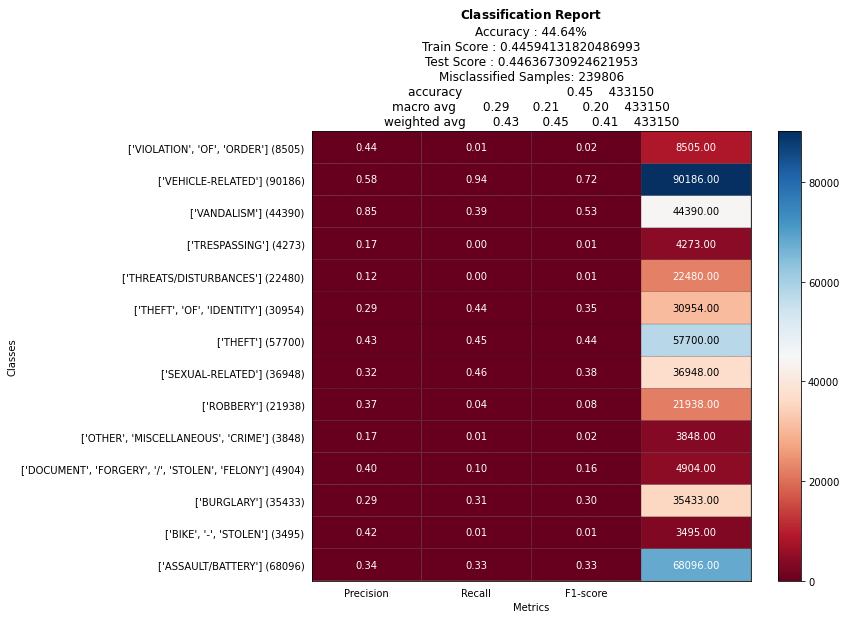

In [36]:
# Display a graph of the classification report
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title, cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        if len(t)>0:
            classes.append(t[:len(t)-4])
        v = [float(x) for x in t[-4:]]
        support.append(int(t[-1]))
        class_names.append(t[:len(t)-4])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

# Print the training score, testing score, accuracy (percentage), number of misclassified labels as the title of the figure
train_score = model.score(X_train_scaled_desc,y_train_desc)
test_score = model.score(X_test_scaled_desc,y_test_desc)
accuracy_desc = metrics.accuracy_score(np.ravel(y_test_desc), y_pred_desc)
accuracy_perc = accuracy_desc*100
count_misclassified_desc = (np.ravel(y_test_desc) != y_pred_desc).sum()
bold = r"$\bf{"+'Classification '+"}$"
bold2 = ' '
bold3 = r"$\bf{"+'Report'+"}$"
not_bold = f'\nAccuracy : {round(accuracy_perc,2)}%\nTrain Score : {train_score}\nTest Score : {test_score}\nMisclassified Samples: {count_misclassified_desc}\naccuracy                           0.45    433150\nmacro avg       0.29      0.21      0.20    433150\nweighted avg       0.43      0.45      0.41    433150'
title = bold + bold2 + bold3 + not_bold

# Plot the classification report
plot_classification_report(classification_report(y_test_desc, y_pred_desc),title)

In [38]:
# SAVING THE MODEL WITH NEW FEATURES
import joblib
joblib.dump(model, 'crime-model-v2.sav')

['crime-model-v2.sav']

## Predict Example VICTIM

**VICTIM 1:**

- Age = 29 years old
- Sex = Female
- Descent = White
- Premis Description = Street
- Lat = 34.0928
- Lon=118.3287
- Area Name = Hollywood
- Season = summer
- day or night = day 

In [ ]:
def predict_person(person_age, person_genderName, person_descentName, person_premisName, person_lat, person_lon, person_areaName, person_seasonName, person_dayNightName):
    '''
    This function takes a person's attributes and returns a dictionary of the most probable crimes that would happen to that person if that person was to be a victim of a crime
    Inputs: Age, Sex, Descent, Premise Description, Latitude, Longitude, Area Name, Season, Day or Night
    Output: Dictionary with the top 5 most probable crimes and their respective probabilities
    '''
    import pandas as pd
    import numpy as np
    
    # Get the dataset from AWS (same dataset as df above)
    url ="https://crime-bucket.s3.amazonaws.com/FINAL_DF.csv"
    df = pd.read_csv(url)
    df = df.drop(columns='Unnamed: 0')
    
    # Include only the relevant columns (the features)
    cols_CrmCdDesc = ['Crm Cd Desc','AREA NAME', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Desc', 'SEASON', 'day_night','NEWlat','NEWlon','NEW_Z']
    data_desc = df[cols_CrmCdDesc]

    # Create the X and y values
    X_desc = data_desc.drop('Crm Cd Desc',axis=1)
    y_desc = data_desc['Crm Cd Desc'].values.reshape(-1,1)
    
    # Dummy encode the X values
    X_encoded_desc = pd.get_dummies(X_desc,columns=['AREA NAME','Vict Sex','Vict Descent','Premis Desc','SEASON','day_night'])
    
    # Preform a train test split on the data
    from sklearn.model_selection import train_test_split
    X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(
      X_encoded_desc, y_desc, random_state=122, stratify=y_desc)
    
    # Scale the X values
    from sklearn.preprocessing import StandardScaler
    X_scaler_desc = StandardScaler().fit(X_train_desc)

    X_train_scaled_desc = X_scaler_desc.transform(X_train_desc)
    X_test_scaled_desc = X_scaler_desc.transform(X_test_desc)

    # Create copy of X_test_desc and extract the first row (to get encoded column names)
    person = X_test_desc.copy()
    person = person.iloc[[0]]
    
    # Populate the respective dummy columns based on the inputs
    # (1) AREA  (EX: person_areaName = 'Van Nuys')
    person_area = 'AREA NAME_' + person_areaName
    person[person_area] = 1
    area_cols = [col for col in person.columns if 'AREA NAME' in col]
    area_cols.remove(person_area)
    person[area_cols] = 0

    # (2) GENDER/SEX  (EX: person_genderName = 'M')
    sex_cols = [col for col in person.columns if 'Vict Sex' in col]
    person_sex = 'Vict Sex_'+person_genderName
    person[person_sex]=1
    sex_cols.remove(person_sex)
    person[sex_cols]=0

    # (3) DESCENT (EX: person_descentName = 'H')
    descent_cols = [col for col in person.columns if 'Vict Descent' in col]
    person_descent = 'Vict Descent_'+person_descentName
    person[person_descent]=1
    descent_cols.remove(person_descent)
    person[descent_cols]=0

    # (4) PREMISE DESCRIPTION (EX: person_premisName = 'LIBRARY')
    premis_cols = [col for col in person.columns if 'Premis Desc' in col]
    person_premis = 'Premis Desc_'+person_premisName
    person[person_premis]=1
    premis_cols.remove(person_premis)
    person[premis_cols]=0

    # (5) SEASON (EX: person_seasonName = 'fall')
    season_cols = [col for col in person.columns if 'SEASON' in col]
    person_season = 'SEASON_'+person_seasonName
    person[person_season]=1
    season_cols.remove(person_season)
    person[season_cols]=0

    # (6) DAY/NIGHT (EX: # person_dayNightName = 'night')
    dayNight_cols = [col for col in person.columns if 'day_night' in col]
    person_dayNight = 'day_night_'+person_dayNightName
    person[person_dayNight]=1
    dayNight_cols.remove(person_dayNight)
    person[dayNight_cols]=0

    # (7) LAT, LON, Z
    person['NEWlat'] = person_lat**2
    person['NEWlon'] = person_lon**2
    person['NEW_Z'] = person_lat*person_lon

    # (8) AGE
    person['Vict Age'] = person_age

    # Load the model
    import joblib
    model2 = joblib.load('crime-model-v2.sav')

    # Scale the data for the person data
    person_scaled = X_scaler_desc.transform(person)
    
    # Make the prediction using the model
    person_pred = model2.predict([person_scaled[0]])
    
    # Predict the probabilities of the crimes for that person
    list2 = []
    for i in zip(model2.classes_, model2.predict_proba([person_scaled[0]])[0]):
        list2.append(i)
        
    # Sort them in ascending order based on the probability
    list2.sort(key = lambda x: x[1])
    
    # Reverse so it shows the most probable crime first
    list2.reverse()
    
    # Get the top 5 most probable crimes if a crime was to happen to the person
    top5 = list2[0:5]
    
    # Create a dictionary of the top 5 most probable crimes and their probabilities
    top5_dict = {}
    for i in top5:
        top5_dict[i[0]]=round(i[1]*100,2)
    # TO get the crime names in the returned dictionary: top5_dict.keys()
    # To get the probabilities of the crimes in the returned dictionary: top5_dict.values()
    return top5_dict

In [ ]:
person_areaName = 'Hollywood'
person_genderName = 'F'
person_descentName = 'W'
person_premisName = 'STREET'
person_seasonName = 'summer'
person_dayNightName = 'day'
person_lat = 34.0928
person_lon = -118.328
person_age = 24
top5_dictionary = predict_person(person_age, person_genderName, person_descentName, person_premisName, person_lat, person_lon, person_areaName, person_seasonName, person_dayNightName)

| Crime | Probability |
|---|---|
|VEHICLE-RELATED   | 51.02%  |
| ASSAULT/BATTERY	  |13.84%   | 
| THEFT  |   8.66% |
|SEXUAL-RELATED| 6.95%|
|VANDALISM|6.75%|

------
------
------
------
### Coefficient Analysis

In [108]:
coef_dict = {}
for coef, feat in zip(model.coef_[0],X_encoded_desc.columns):
    coef_dict[feat] = coef
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df = coef_df.rename(columns={0:'Coef'})
coef_df.loc[coef_df['Coef']==coef_df['Coef'].values.min()]

,Coef
Vict Sex_X,-0.97658


In [101]:
coef_dict

{'AREA NAME_77th Street': 0.055779124972703736,
 'AREA NAME_Central': 0.06587606257973277,
 'AREA NAME_Devonshire': -0.07325226894394629,
 'AREA NAME_Foothill': -0.010060861863729145,
 'AREA NAME_Harbor': 0.024172959539031088,
 'AREA NAME_Hollenbeck': 0.07023860881339296,
 'AREA NAME_Hollywood': -0.01648566382619807,
 'AREA NAME_Mission': 0.006961051218531329,
 'AREA NAME_N Hollywood': -0.034783150601019226,
 'AREA NAME_Newton': 0.04085617390941911,
 'AREA NAME_Northeast': -0.02535447173991174,
 'AREA NAME_Olympic': 0.09921727036055294,
 'AREA NAME_Pacific': -0.043645117241551,
 'AREA NAME_Rampart': 0.009370804789666782,
 'AREA NAME_Southeast': 0.05294403027024385,
 'AREA NAME_Southwest': -0.013863481851870071,
 'AREA NAME_Topanga': -0.015406280026822898,
 'AREA NAME_Van Nuys': -0.06439177155841459,
 'AREA NAME_West LA': -0.03499490231601727,
 'AREA NAME_West Valley': -0.06498126703182136,
 'AREA NAME_Wilshire': -0.009547493044756725,
 'NEW_Z': -0.02510588972441494,
 'NEWlat': -0.00985

In [71]:
classification_report(y_test_desc, y_pred_desc, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ASSAULT/BATTERY': {'f1-score': 0.35941797324933594,
  'precision': 0.3413708417057379,
  'recall': 0.3794797974784076,
  'support': 20146},
 'BIKE - STOLEN': {'f1-score': 0.00784313725490196,
  'precision': 0.3333333333333333,
  'recall': 0.003968253968253968,
  'support': 252},
 'BRANDISH WEAPON': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 542},
 'BURGLARY': {'f1-score': 0.32848549455569936,
  'precision': 0.2902119071644803,
  'recall': 0.37838786071397246,
  'support': 11401},
 'CRIMINAL THREATS - NO WEAPON DISPLAYED': {'f1-score': 0.002995293110825845,
  'precision': 0.10144927536231885,
  'recall': 0.0015200868621064061,
  'support': 4605},
 'DOCUMENT FORGERY / STOLEN FELONY': {'f1-score': 0.1882716049382716,
  'precision': 0.4609571788413098,
  'recall': 0.1182934712346477,
  'support': 1547},
 'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 1881},
 'OTHER MISCELLANEOUS CRIME': {'f1-score': 